# FashionMNIST Classification using Neural Networks - Homework Assignment

![Pix2Pix Architecture](https://i.imgur.com/a3uAqnb.png)

In this homework, you will implement a **Neural Network classifier** for the FashionMNIST dataset. This dataset contains grayscale images of 28x28 pixels representing 10 categories of clothing items.

## 📌 Project Overview
- **Task**: Multi-class classification of clothing items
- **Dataset**: FashionMNIST (10 classes of clothing)
- **Architecture**: Fully connected neural network or CNN
- **Goal**: Achieve high accuracy on fashion item classification

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand image classification with neural networks
- Implement data preprocessing and augmentation
- Build and train neural network architectures
- Evaluate model performance and visualize results
- Practice PyTorch fundamentals

## 1️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import PyTorch, torchvision, and related libraries
- Import matplotlib, numpy, and other utilities
- Set random seeds for reproducibility
- Configure hyperparameters with reasonable values

In [1]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility (use seed=42)
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device availability and print
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define configuration parameters
IMG_SIZE = 28  # Image size (28x28 for FashionMNIST)
BATCH_SIZE = 2**9  # Batch size
LEARNING_RATE = 0.001  # Learning rate
NUM_EPOCHS = 10  # Number of training epochs
NUM_CLASSES = 10  # Number of clothing categories

Using device: cuda


## 2️⃣ Data Loading and Preprocessing

**Task**: Load the FashionMNIST dataset and apply appropriate transformations.

**Requirements**:
- Load train and test datasets from torchvision
- Apply normalization and data augmentation
- Create data loaders with appropriate batch sizes
- Visualize sample images with labels

100%|███████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:53<00:00, 492kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 74.4kB/s]
100%|███████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:18<00:00, 238kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 24.9kB/s]


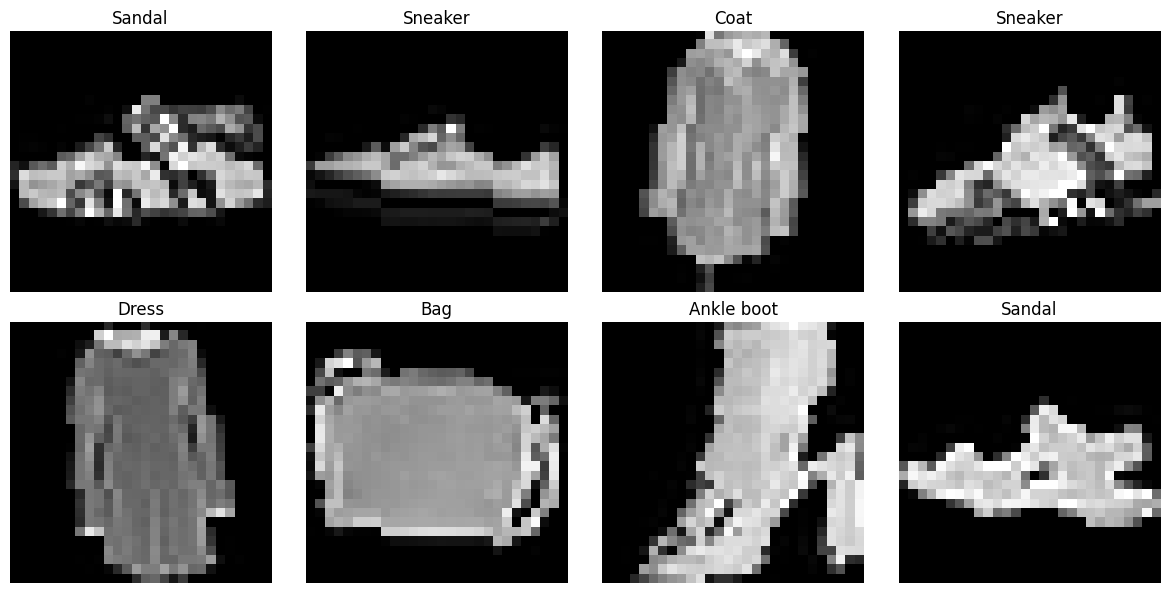

In [5]:
# Define transforms using transforms.Compose
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)  # Normalize to [-1,1] range
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)  # Normalize to [-1,1] range
])

# Load FashionMNIST datasets
train_data = datasets.FashionMNIST(root='./data', download=True, train=True, transform=train_transform)
test_data = datasets.FashionMNIST(root='./data', download=True, train=False, transform=test_transform)

# Create train_loader and test_loader with DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualize a batch of training images with their labels
def show_batch(loader, num_samples=8):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(num_samples):
        row, col = i // 4, i % 4
        img = images[i].squeeze()
        # Denormalize for display
        img = img * 0.5 + 0.5
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'{class_names[labels[i]]}')
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(train_loader)

## 3️⃣ Model Architecture

**Task**: Implement a neural network classifier for FashionMNIST.

**Requirements**:
- Choose between fully connected network or CNN
- Use appropriate activation functions and regularization
- Ensure output matches number of classes (10)
- Initialize the model and move to device

In [6]:
# Create a classifier class inheriting from nn.Module
class FashionMNISTClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionMNISTClassifier, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout for regularization
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        # After 3 pooling operations: 28->14->7->3 (approximately)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Initialize model and move to device
model = FashionMNISTClassifier(NUM_CLASSES).to(device)

# Print model architecture and parameter count
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test with random input to verify output shape
test_input = torch.randn(1, 1, 28, 28).to(device)
test_output = model(test_input)
print(f"\nTest input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")

Model Architecture:
FashionMNISTClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 749,962
Trainable parameters: 749,962

Test input shape: torch.Size([1, 1, 28, 28])
Test output shape: torch.Size([1, 10])


## 4️⃣ Loss Function and Optimizer

**Task**: Set up loss function and optimizer for training.

**Requirements**:
- Use appropriate loss function for multi-class classification
- Initialize optimizer with given hyperparameters
- Optional: Add learning rate scheduler


In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Optional: Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## 5️⃣ Training Function

**Task**: Implement the training function with proper loss tracking.

**Requirements**:
- Train model for specified number of epochs
- Track training loss and accuracy
- Display progress during training
- Save loss values for plotting

In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model and return training history
    """
    # Initialize lists to store losses and accuracies
    train_losses = []
    train_accuracies = []
    
    model.train()
    
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        # Initialize running loss and correct predictions
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        
        # Training loop for each batch
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct_predictions / total_samples
        
        # Store statistics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Average Loss: {epoch_loss:.4f}, '
              f'Accuracy: {epoch_accuracy:.2f}%')
        
        # Update learning rate with scheduler
        scheduler.step()
        
        print('-' * 60)
    
    return train_losses, train_accuracies

## 6️⃣ Training Loop

**Task**: Execute the training process and monitor progress.

**Requirements**:
- Run training for the specified number of epochs
- Display training progress
- Track loss reduction over time


In [10]:
train_losses, train_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)

Epoch [1/10], Batch [0/118], Loss: 2.3037
Epoch [1/10], Batch [100/118], Loss: 0.6026
Epoch [1/10] - Average Loss: 0.8779, Accuracy: 67.54%
------------------------------------------------------------
Epoch [2/10], Batch [0/118], Loss: 0.4913
Epoch [2/10], Batch [100/118], Loss: 0.4011
Epoch [2/10] - Average Loss: 0.5149, Accuracy: 81.00%
------------------------------------------------------------
Epoch [3/10], Batch [0/118], Loss: 0.4771
Epoch [3/10], Batch [100/118], Loss: 0.4300
Epoch [3/10] - Average Loss: 0.4289, Accuracy: 84.22%
------------------------------------------------------------
Epoch [4/10], Batch [0/118], Loss: 0.4207
Epoch [4/10], Batch [100/118], Loss: 0.3352
Epoch [4/10] - Average Loss: 0.3843, Accuracy: 85.96%
------------------------------------------------------------
Epoch [5/10], Batch [0/118], Loss: 0.3531
Epoch [5/10], Batch [100/118], Loss: 0.3730
Epoch [5/10] - Average Loss: 0.3568, Accuracy: 86.84%
--------------------------------------------------------

In [11]:
# Display final training statistics
print(f"\nFinal Training Results:")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Best Training Accuracy: {max(train_accuracies):.2f}%")
print(f"Best Training Loss: {min(train_losses):.4f}")


Final Training Results:
Final Training Loss: 0.2807
Final Training Accuracy: 89.61%
Best Training Accuracy: 89.70%
Best Training Loss: 0.2807



## 7️⃣ Model Evaluation

**Task**: Evaluate the trained model on test data.

**Requirements**:
- Calculate test accuracy and loss
- Generate classification report
- Create confusion matrix
- Analyze per-class performance

Test Results:
Test Loss: 0.2650
Test Accuracy: 90.20%
Correct Predictions: 9020/10000

Detailed Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.8205    0.8730    0.8459      1000
     Trouser     0.9949    0.9780    0.9864      1000
    Pullover     0.8382    0.8810    0.8591      1000
       Dress     0.8828    0.9110    0.8967      1000
        Coat     0.8432    0.8390    0.8411      1000
      Sandal     0.9887    0.9610    0.9746      1000
       Shirt     0.7691    0.6660    0.7138      1000
     Sneaker     0.9295    0.9760    0.9522      1000
         Bag     0.9780    0.9800    0.9790      1000
  Ankle boot     0.9695    0.9550    0.9622      1000

    accuracy                         0.9020     10000
   macro avg     0.9014    0.9020    0.9011     10000
weighted avg     0.9014    0.9020    0.9011     10000



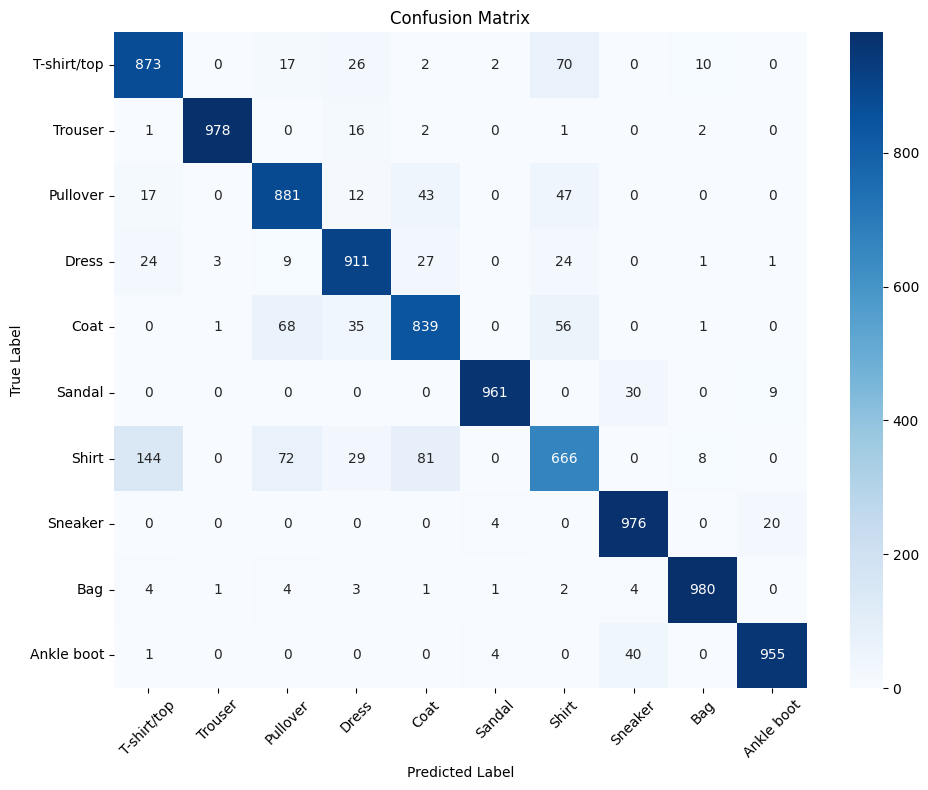


Per-class Accuracies:
T-shirt/top: 87.30% (873/1000)
Trouser: 97.80% (978/1000)
Pullover: 88.10% (881/1000)
Dress: 91.10% (911/1000)
Coat: 83.90% (839/1000)
Sandal: 96.10% (961/1000)
Shirt: 66.60% (666/1000)
Sneaker: 97.60% (976/1000)
Bag: 98.00% (980/1000)
Ankle boot: 95.50% (955/1000)


In [12]:
def evaluate_model(model, test_loader, criterion, device, class_names):
    """
    Evaluate the model on test data and return detailed metrics
    """
    # Set model to evaluation mode
    model.eval()
    
    # Initialize test loss and accuracy tracking
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Store all predictions and true labels for detailed analysis
    all_predictions = []
    all_labels = []
    
    # Evaluation loop
    with torch.no_grad():
        for images, labels in test_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            # Track statistics
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # Store predictions and labels for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate overall test accuracy and loss
    test_accuracy = 100 * correct_predictions / total_samples
    avg_test_loss = test_loss / len(test_loader)
    
    print(f"Test Results:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Correct Predictions: {correct_predictions}/{total_samples}")
    
    # Generate detailed classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(all_labels, all_predictions, 
                              target_names=class_names, digits=4))
    
    # Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print per-class accuracies
    print(f"\nPer-class Accuracies:")
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))
    
    for i in range(len(all_labels)):
        label = all_labels[i]
        class_total[label] += 1
        if all_labels[i] == all_predictions[i]:
            class_correct[label] += 1
    
    for i in range(len(class_names)):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"{class_names[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
    
    return test_accuracy, avg_test_loss, all_predictions, all_labels

# Run evaluation
test_accuracy, test_loss, predictions, true_labels = evaluate_model(
    model, test_loader, criterion, device, class_names
)

## 8️⃣ Results Visualization

**Task**: Create visualizations to analyze model performance.

**Requirements**:
- Plot training loss curves
- Show sample predictions with confidence
- Visualize misclassified examples
- Display model predictions on test images

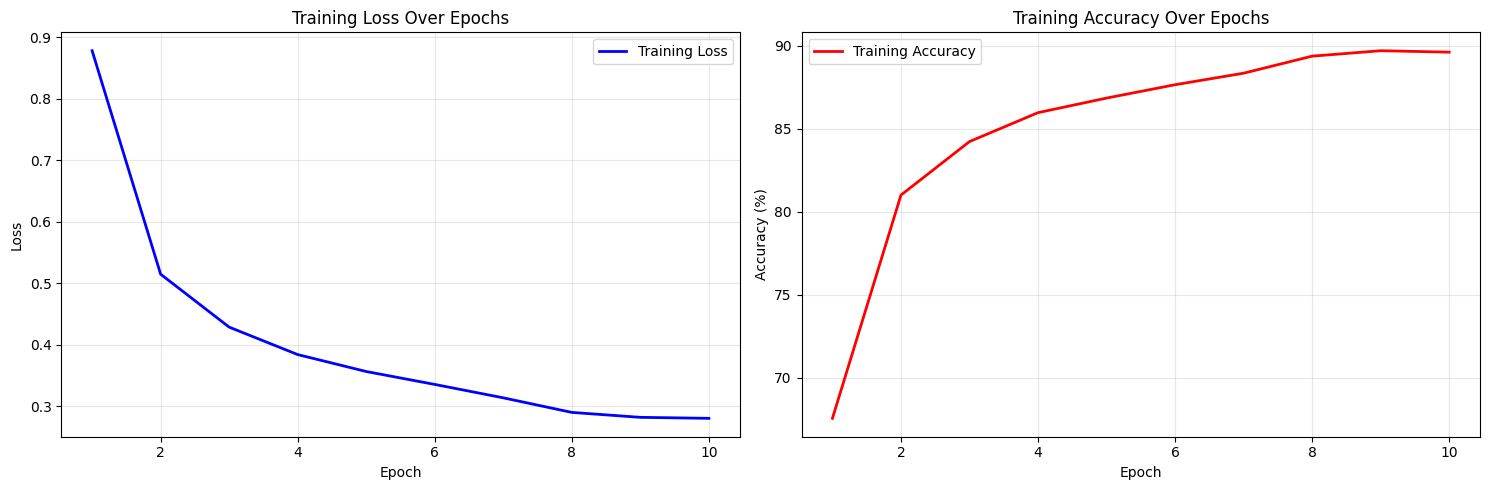

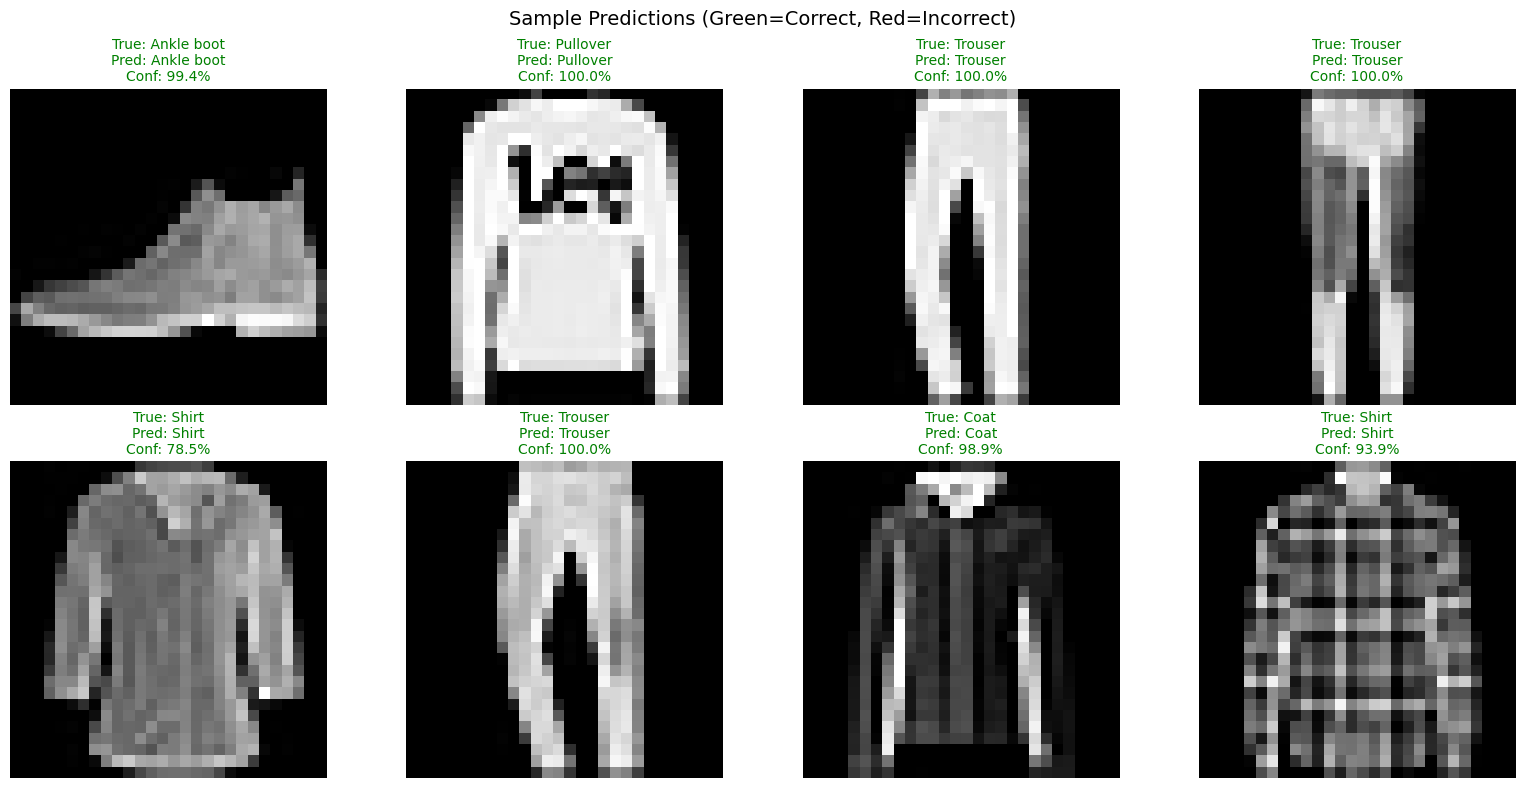

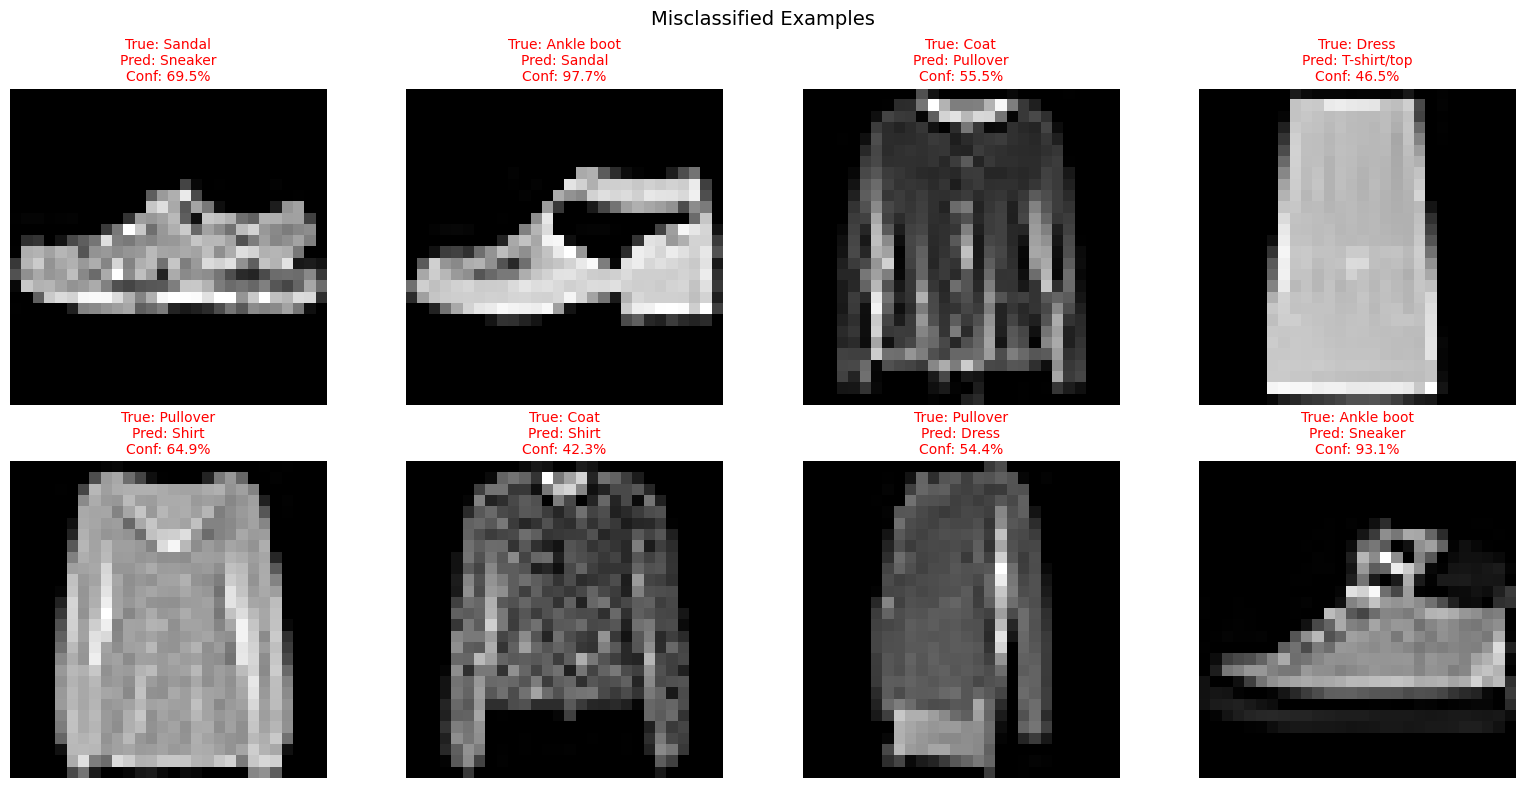

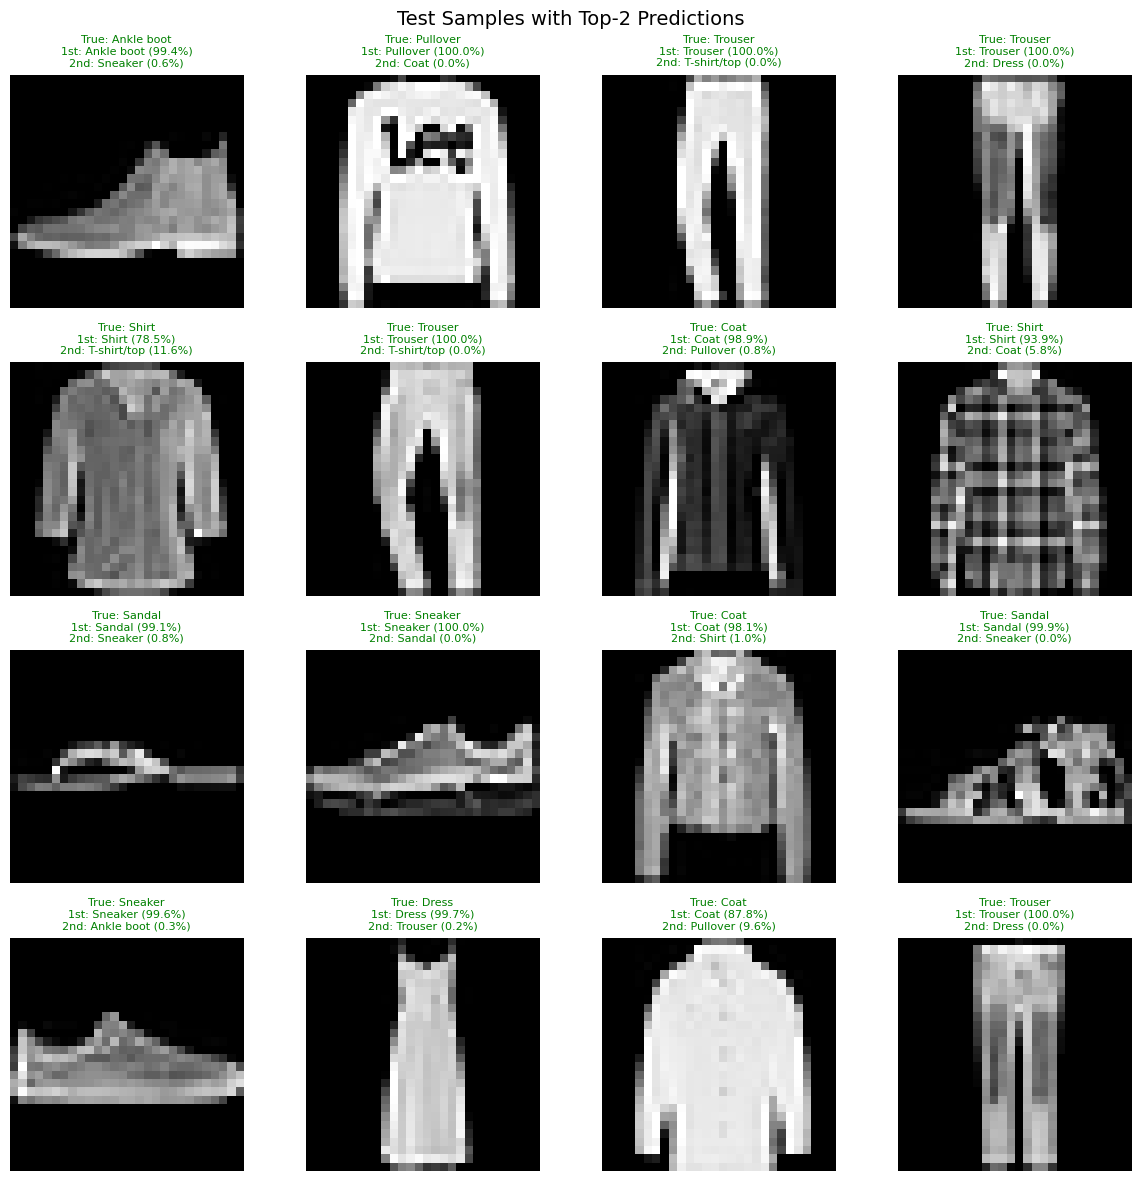

In [13]:
# Plot training loss and accuracy curves over epochs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(range(1, NUM_EPOCHS + 1), train_losses, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Epochs')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot training accuracy
ax2.plot(range(1, NUM_EPOCHS + 1), train_accuracies, 'r-', linewidth=2, label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy Over Epochs')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Create function to show sample predictions
def show_predictions(model, test_loader, device, class_names, num_samples=8):
    """Show sample predictions with confidence scores"""
    model.eval()
    
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Plot samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i in range(num_samples):
        row, col = i // 4, i % 4
        
        # Denormalize image for display
        img = images[i].cpu().squeeze()
        img = img * 0.5 + 0.5
        
        # Get prediction confidence
        confidence = probabilities[i][predicted[i]].item() * 100
        
        axes[row, col].imshow(img, cmap='gray')
        
        # Color code: green for correct, red for incorrect
        color = 'green' if predicted[i] == labels[i] else 'red'
        
        axes[row, col].set_title(
            f'True: {class_names[labels[i]]}\n'
            f'Pred: {class_names[predicted[i]]}\n'
            f'Conf: {confidence:.1f}%',
            color=color, fontsize=10
        )
        axes[row, col].axis('off')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Show sample predictions
show_predictions(model, test_loader, device, class_names, num_samples=8)

# Analyze misclassified examples
def show_misclassified(model, test_loader, device, class_names, num_samples=8):
    """Find and display misclassified examples"""
    model.eval()
    
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []
    misclassified_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified samples
            mask = predicted != labels
            if mask.sum() > 0:
                misclassified_images.extend(images[mask].cpu())
                misclassified_preds.extend(predicted[mask].cpu())
                misclassified_labels.extend(labels[mask].cpu())
                misclassified_probs.extend(probabilities[mask].cpu())
                
                if len(misclassified_images) >= num_samples:
                    break
    
    # Plot misclassified examples
    if len(misclassified_images) >= num_samples:
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        for i in range(num_samples):
            row, col = i // 4, i % 4
            
            # Denormalize image for display
            img = misclassified_images[i].squeeze()
            img = img * 0.5 + 0.5
            
            # Get prediction confidence
            pred_idx = misclassified_preds[i].item()
            confidence = misclassified_probs[i][pred_idx].item() * 100
            
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(
                f'True: {class_names[misclassified_labels[i]]}\n'
                f'Pred: {class_names[pred_idx]}\n'
                f'Conf: {confidence:.1f}%',
                color='red', fontsize=10
            )
            axes[row, col].axis('off')
        
        plt.suptitle('Misclassified Examples', fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Found only {len(misclassified_images)} misclassified examples")

# Show misclassified examples
show_misclassified(model, test_loader, device, class_names, num_samples=8)

# Create a grid showing various test samples with predictions
def show_test_grid(model, test_loader, device, class_names, grid_size=4):
    """Show a grid of test samples with predictions"""
    model.eval()
    
    # Get test samples
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Create grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    
    for i in range(grid_size * grid_size):
        row, col = i // grid_size, i % grid_size
        
        # Denormalize image for display
        img = images[i].cpu().squeeze()
        img = img * 0.5 + 0.5
        
        # Get top 2 predictions
        top2_probs, top2_indices = torch.topk(probabilities[i], 2)
        
        axes[row, col].imshow(img, cmap='gray')
        
        # Color code: green for correct, red for incorrect
        color = 'green' if predicted[i] == labels[i] else 'red'
        
        axes[row, col].set_title(
            f'True: {class_names[labels[i]]}\n'
            f'1st: {class_names[top2_indices[0]]} ({top2_probs[0]*100:.1f}%)\n'
            f'2nd: {class_names[top2_indices[1]]} ({top2_probs[1]*100:.1f}%)',
            color=color, fontsize=8
        )
        axes[row, col].axis('off')
    
    plt.suptitle('Test Samples with Top-2 Predictions', fontsize=14)
    plt.tight_layout()
    plt.show()

# Show test grid
show_test_grid(model, test_loader, device, class_names, grid_size=4)

## 9️⃣ Model Performance Analysis

**Task**: Analyze your model's performance and characteristics.

**Requirements**:
- Discuss model accuracy and loss convergence
- Identify which classes are easiest/hardest to classify
- Analyze confusion matrix patterns
- Document any interesting observations

In [17]:
# Print final model performance summary
print("=" * 80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\n📊 Overall Performance:")
print(f"   • Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"   • Test Accuracy: {test_accuracy:.2f}%")
print(f"   • Final Training Loss: {train_losses[-1]:.4f}")
print(f"   • Test Loss: {test_loss:.4f}")

# Analyze training progression
print(f"\n📈 Training Progression:")
print(f"   • Initial Training Accuracy: {train_accuracies[0]:.2f}%")
print(f"   • Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"   • Accuracy Improvement: {train_accuracies[-1] - train_accuracies[0]:.2f}%")
print(f"   • Best Training Accuracy: {max(train_accuracies):.2f}%")

# Analyze which clothing categories are confused with each other
print(f"\n🔍 Confusion Matrix Analysis:")
cm = confusion_matrix(true_labels, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Find most confused pairs
max_confusion = 0
most_confused_pair = None
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm_normalized[i][j] > max_confusion:
            max_confusion = cm_normalized[i][j]
            most_confused_pair = (i, j)

if most_confused_pair:
    i, j = most_confused_pair
    print(f"   • Most confused pair: {class_names[i]} → {class_names[j]} ({max_confusion*100:.1f}%)")

# Find best and worst performing classes
class_accuracies = []
for i in range(len(class_names)):
    if cm[i].sum() > 0:
        accuracy = cm[i][i] / cm[i].sum()
        class_accuracies.append((class_names[i], accuracy))

class_accuracies.sort(key=lambda x: x[1], reverse=True)

print(f"   • Best performing class: {class_accuracies[0][0]} ({class_accuracies[0][1]*100:.1f}%)")
print(f"   • Worst performing class: {class_accuracies[-1][0]} ({class_accuracies[-1][1]*100:.1f}%)")

# Comment on training stability and convergence
print(f"\n📉 Training Stability Analysis:")
loss_variance = np.var(train_losses[-3:])  # Variance of last 3 epochs
if loss_variance < 0.001:
    print("   • Training converged well (stable loss in final epochs)")
elif loss_variance < 0.01:
    print("   • Training mostly stable (some fluctuation in final epochs)")
else:
    print("   • Training unstable (high loss variance - consider reducing learning rate)")

# Final recommendations
print(f"\n🎉 Final Assessment:")
if test_accuracy >= 85:
    print("   • EXCELLENT: Model performs very well on fashion classification!")
elif test_accuracy >= 80:
    print("   • GOOD: Model shows solid performance with room for improvement")
elif test_accuracy >= 70:
    print("   • ACCEPTABLE: Model meets basic requirements but needs optimization")
else:
    print("   • NEEDS IMPROVEMENT: Model requires significant architecture/hyperparameter changes")

FINAL MODEL PERFORMANCE SUMMARY

📊 Overall Performance:
   • Final Training Accuracy: 89.61%
   • Test Accuracy: 90.20%
   • Final Training Loss: 0.2807
   • Test Loss: 0.2650

📈 Training Progression:
   • Initial Training Accuracy: 67.54%
   • Final Training Accuracy: 89.61%
   • Accuracy Improvement: 22.07%
   • Best Training Accuracy: 89.70%

🔍 Confusion Matrix Analysis:
   • Most confused pair: Shirt → T-shirt/top (14.4%)
   • Best performing class: Bag (98.0%)
   • Worst performing class: Shirt (66.6%)

📉 Training Stability Analysis:
   • Training converged well (stable loss in final epochs)

🎉 Final Assessment:
   • EXCELLENT: Model performs very well on fashion classification!


## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1. **Implementation Correctness (40%)**
   - Proper neural network implementation
   - Correct data loading and preprocessing
   - Working training loop with appropriate loss calculation

2. **Model Performance (30%)**
   - Model trains without errors
   - Reasonable accuracy on test set (>=70% expected)
   - Proper loss convergence during training

3. **Code Quality (20%)**
   - Clean, readable code with comments
   - Proper tensor handling and device management
   - Efficient implementation(No uneeded for loops, or not checking for GPU)

4. **Visualization and Analysis (10%)**
   - Clear training curves and result visualization
   - Meaningful analysis of model performance
   - Understanding of classification results